In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('training_data_filled_11.09.csv')
df.drop(columns=['prepayment'], inplace=True)

## Бинарная классификация

### Разбиваем данные на классы по порогам

In [3]:
df['reduction_0'] = df.penalty_reduction_ratio == 0
df['reduction_up_to_20'] = df.penalty_reduction_ratio <= 0.2
df['reduction_up_to_40'] = df.penalty_reduction_ratio <= 0.4
df['reduction_up_to_50'] = df.penalty_reduction_ratio <= 0.5
df['reduction_up_to_80'] = df.penalty_reduction_ratio <= 0.8

In [4]:
total = 0
for col in ['reduction_0', 'reduction_up_to_20', 'reduction_up_to_40', 'reduction_up_to_50',
            'reduction_up_to_80']:
    print(col, ': posittive --', sum(df[col]), ', negative --', len(df[col]) - sum(df[col]))
    total += sum(df[col])

reduction_0 : posittive -- 23 , negative -- 102
reduction_up_to_20 : posittive -- 28 , negative -- 97
reduction_up_to_40 : posittive -- 36 , negative -- 89
reduction_up_to_50 : posittive -- 57 , negative -- 68
reduction_up_to_80 : posittive -- 94 , negative -- 31


### Синтезируем признаки

In [5]:
df['predicted_claimed_penalty'] = [
    contract_penalty_percentage * contract_price * delay
    for (contract_penalty_percentage, contract_price, delay)
    in df[['contract_penalty_percentage', 'contract_price', 'delay']].values
]
df['predicted_claimed_penalty'] = df['predicted_claimed_penalty'].astype(int)

In [6]:
df['total_claimed_debt'] = [
    claimed_penalty + debt_amount
    for (claimed_penalty, debt_amount)
    in df[['claimed_penalty', 'debt_amount']].values
]

In [29]:
df['penalty_per_day'] = [
    claimed_penalty / delay
    for (claimed_penalty, delay)
    in df[['claimed_penalty', 'delay']].values
]
df['price_per_penalty'] = [
    contract_price / claimed_penalty
    for (contract_price, claimed_penalty)
    in df[['contract_price', 'claimed_penalty']].values
]
df['price_per_debt'] = [
    contract_price / debt_amount
    for (contract_price, debt_amount)
    in df[['contract_price', 'debt_amount']].values
]

In [27]:
df['x1'] = [
    claimed_penalty * contract_penalty_percentage
    for (claimed_penalty, contract_penalty_percentage)
    in df[['claimed_penalty', 'contract_penalty_percentage']].value
]
df['x2'] = [
    claimed_penalty * contract_penalty_percentage
    for (claimed_penalty, contract_penalty_percentage)
    in df[['claimed_penalty', 'contract_penalty_percentage']].value
]

,claimed_penalty,contract_penalty_percentage,contract_price,delay,debt_amount,penalty_reduction_ratio,appeal_courts,type_of_contract,judge_gender,year,undefined_contract_price,reduction_0,reduction_up_to_20,reduction_up_to_40,reduction_up_to_50,reduction_up_to_80,predicted_claimed_penalty,total_claimed_debt
0,68246341,0.001,73632148.0,1209.0,51515008.0,0.934062,13 апелляция,Поставка,Судья - женщина,2022 год,False,False,False,False,False,False,89021266,119761349.0
1,1343806,0.002,20285289.0,138.0,431713.0,0.500000,13 апелляция,Подряд,Судья - мужчина,2022 год,False,False,False,False,True,True,5598739,1775519.0
2,1624644,0.010,5802301.0,27.0,4416609.2,0.384481,13 апелляция,Поставка,Судья - женщина,2022 год,False,False,False,True,True,True,1566621,6041253.2
3,1518650,0.001,18988693.0,163.0,3561550.2,0.341520,13 апелляция,Поставка,Судья - женщина,2022 год,False,False,False,True,True,True,3095156,5080200.2
4,3964216,0.005,12197590.0,64.0,2197590.0,0.445643,13 апелляция,Поставка,Судья - женщина,2022 год,False,False,False,False,True,True,3903228,6161806.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,294744,0.005,149886.0,392.0,149886.0,0.795731,15 апелляция,Поставка,Судья - мужчина,2022 год,False,False,False,False,False,True,293776,444630.0
121,603526,0.100,6035268.0,150.0,6035268.0,0.900001,15 апелляция,Поставка,Судья - женщина,2023 год,False,False,False,False,False,False,90529020,6638794.0
122,77298,0.003,48341.0,533.0,48341.0,0.666667,15 апелляция,Поставка,Судья - мужчина,2022 год,False,False,False,False,False,True,77297,125639.0
123,18020319,0.001,2955224.8,122.0,3499356.2,0.334085,13 апелляция,Подряд,Судья - женщина,2021 год,True,False,False,True,True,True,360537,21519675.2


### Добавляем категориальные признаки

In [7]:
def transform_into_onehot(column_name, df):
    encoding_dict = {
        c: i for (i, c) in enumerate(df[column_name].unique())
    }
    encoded = np.zeros((len(df), len(encoding_dict)))
    for i, val in enumerate(df[column_name]):
        one_place = encoding_dict[val]
        encoded[i][one_place] = 1
    return encoded

In [8]:
encoded_type_of_contract = transform_into_onehot('type_of_contract', df)
encoded_appeal_courts = transform_into_onehot('appeal_courts', df)
encoded_judge_gender = transform_into_onehot('judge_gender', df)
encoded_year = transform_into_onehot('year', df)

In [42]:
features = df[[
    'claimed_penalty', 'contract_penalty_percentage', 'contract_price', 'delay',
    'debt_amount', 'penalty_per_day', 'price_per_penalty', 'price_per_debt'
]].values

In [43]:
features = np.hstack([features, encoded_type_of_contract, encoded_appeal_courts, encoded_judge_gender, encoded_year])

### Разделяем на train и test

In [44]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(
    features, df.reduction_0, test_size=0.3, random_state=42)
sum(y_train), sum(y_test)

(14, 9)

### Обучаем модель

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

#### LogisticRegression

In [45]:
clf = LogisticRegression(class_weight={True: 5, False: 1})
clf.fit(X_train, y_train)

LogisticRegression(class_weight={False: 1, True: 5})

Заполняем цену контракта предсказанными значениями из KNNRegressor. Стало лучше:

In [16]:
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       False       0.88      1.00      0.94        29
        True       1.00      0.56      0.71         9

    accuracy                           0.89        38
   macro avg       0.94      0.78      0.82        38
weighted avg       0.91      0.89      0.88        38



После аугментации признаков:

In [35]:
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       False       0.93      0.90      0.91        29
        True       0.70      0.78      0.74         9

    accuracy                           0.87        38
   macro avg       0.81      0.84      0.82        38
weighted avg       0.87      0.87      0.87        38



In [17]:
# вероятность класса 0 (снижение -- 0%)
probas = clf.predict_proba(X_test)[:, 1]
results = pd.DataFrame({'is_0_class': y_test, 'probability_of_0_class': probas})
results[results['is_0_class']]

,is_0_class,probability_of_0_class
36,True,0.498859
53,True,0.580854
56,True,0.999011
27,True,0.503920
44,True,0.501540
19,True,0.285230
47,True,0.490569
45,True,0.484354
22,True,0.635031


## Разделитель -- 20%

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    features, df.reduction_up_to_20, test_size=0.3, random_state=42)

### LogReg

In [48]:
clf = LogisticRegression(class_weight={True: 4, False: 1})
clf.fit(X_train, y_train)

LogisticRegression(class_weight={False: 1, True: 4})

In [23]:
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       False       0.88      0.75      0.81        28
        True       0.50      0.70      0.58        10

    accuracy                           0.74        38
   macro avg       0.69      0.72      0.70        38
weighted avg       0.78      0.74      0.75        38



После заполнения суммы долга моделью:

In [19]:
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       False       0.92      0.79      0.85        28
        True       0.57      0.80      0.67        10

    accuracy                           0.79        38
   macro avg       0.74      0.79      0.76        38
weighted avg       0.83      0.79      0.80        38



После аугментации признаков:

In [49]:
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       False       0.95      0.75      0.84        28
        True       0.56      0.90      0.69        10

    accuracy                           0.79        38
   macro avg       0.76      0.82      0.77        38
weighted avg       0.85      0.79      0.80        38



In [21]:
# probas = dt_clf.predict_proba(X_test)[:, 1]
# results = pd.DataFrame({'is_<20_class': y_test, 'probability_of_<20_class': probas})
# results[results['is_<20_class']]

### RandomForest

In [20]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

In [23]:
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       False       0.79      0.96      0.87        28
        True       0.75      0.30      0.43        10

    accuracy                           0.79        38
   macro avg       0.77      0.63      0.65        38
weighted avg       0.78      0.79      0.75        38



In [24]:
# probas = dt_clf.predict_proba(X_test)[:, 1]
# results = pd.DataFrame({'is_<20_class': y_test, 'probability_of_<20_class': probas})
# results[results['is_<20_class']]

## Разделитель -- 40%

In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    features, df.reduction_up_to_40, test_size=0.3, random_state=42)

### LogReg

In [51]:
clf = LogisticRegression(class_weight={True: 3, False: 1})
clf.fit(X_train, y_train)

LogisticRegression(class_weight={False: 1, True: 3})

In [25]:
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       False       0.71      0.58      0.64        26
        True       0.35      0.50      0.41        12

    accuracy                           0.55        38
   macro avg       0.53      0.54      0.53        38
weighted avg       0.60      0.55      0.57        38



In [27]:
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       False       0.78      0.54      0.64        26
        True       0.40      0.67      0.50        12

    accuracy                           0.58        38
   macro avg       0.59      0.60      0.57        38
weighted avg       0.66      0.58      0.59        38



После аугментации признаков:

In [52]:
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       False       0.84      0.62      0.71        26
        True       0.47      0.75      0.58        12

    accuracy                           0.66        38
   macro avg       0.66      0.68      0.65        38
weighted avg       0.73      0.66      0.67        38



In [53]:
# probas = clf.predict_proba(X_test)[:, 1]
# results = pd.DataFrame({'is_<40_class': y_test, 'probability_of_<40_class': probas})
# results[results['is_<40_class']]

## Разделитель -- 50%

In [54]:
X_train, X_test, y_train, y_test = train_test_split(
    features, df.reduction_up_to_50, test_size=0.3, random_state=42)

### LogReg

In [55]:
clf = LogisticRegression(class_weight={True: 3, False: 1})
clf.fit(X_train, y_train)

LogisticRegression(class_weight={False: 1, True: 3})

In [29]:
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       False       0.55      0.30      0.39        20
        True       0.48      0.72      0.58        18

    accuracy                           0.50        38
   macro avg       0.51      0.51      0.48        38
weighted avg       0.52      0.50      0.48        38



In [31]:
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       False       0.60      0.45      0.51        20
        True       0.52      0.67      0.59        18

    accuracy                           0.55        38
   macro avg       0.56      0.56      0.55        38
weighted avg       0.56      0.55      0.55        38



После аугментации признаков:

In [56]:
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       False       0.50      0.25      0.33        20
        True       0.46      0.72      0.57        18

    accuracy                           0.47        38
   macro avg       0.48      0.49      0.45        38
weighted avg       0.48      0.47      0.44        38



In [35]:
# probas = clf.predict_proba(X_test)[:, 1]
# results = pd.DataFrame({'is_<50_class': y_test, 'probability_of_<50_class': probas})
# results[results['is_<50_class']]

## Разделитель -- 80%

In [57]:
X_train, X_test, y_train, y_test = train_test_split(
    features, df.reduction_up_to_80, test_size=0.3, random_state=42)

### LogReg

In [58]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

In [32]:
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       False       0.46      0.60      0.52        10
        True       0.84      0.75      0.79        28

    accuracy                           0.71        38
   macro avg       0.65      0.68      0.66        38
weighted avg       0.74      0.71      0.72        38



После аугментации признаков:

In [59]:
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       False       0.55      0.60      0.57        10
        True       0.85      0.82      0.84        28

    accuracy                           0.76        38
   macro avg       0.70      0.71      0.70        38
weighted avg       0.77      0.76      0.77        38



In [39]:
# probas = clf.predict_proba(X_test)[:, 1]
# results = pd.DataFrame({'is_<80_class': y_test, 'probability_of_<80_class': probas})
# results[results['is_<80_class']]

## Мультиклассовая классификация

In [60]:
def get_label(ratio):
    if ratio == 0:
        return 'reduction_0'
    
    if ratio <= 0.4:
        return 'reduction_1_to_40'
    
    if ratio <= 0.75:
        return 'reduction_41_to_75'
    
    return 'reduction_76_to_100'

In [61]:
df['range'] = df.penalty_reduction_ratio.apply(get_label)

In [62]:
df.range.value_counts()

reduction_41_to_75     52
reduction_76_to_100    37
reduction_0            23
reduction_1_to_40      13
Name: range, dtype: int64

In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    features, df.range, test_size=0.3, random_state=11)

In [66]:
dt_clf = RandomForestClassifier()
dt_clf.fit(X_train, y_train)

RandomForestClassifier()

In [45]:
pred = dt_clf.predict(X_test)
print(classification_report(y_test, pred))

                     precision    recall  f1-score   support

        reduction_0       0.67      0.50      0.57         8
  reduction_1_to_40       0.00      0.00      0.00         6
 reduction_41_to_75       0.35      0.54      0.42        13
reduction_76_to_100       0.55      0.55      0.55        11

           accuracy                           0.45        38
          macro avg       0.39      0.40      0.39        38
       weighted avg       0.42      0.45      0.42        38



In [41]:
pred = dt_clf.predict(X_test)
print(classification_report(y_test, pred))

                     precision    recall  f1-score   support

        reduction_0       0.67      0.50      0.57         8
  reduction_1_to_40       0.50      0.17      0.25         6
 reduction_41_to_75       0.35      0.54      0.42        13
reduction_76_to_100       0.40      0.36      0.38        11

           accuracy                           0.42        38
          macro avg       0.48      0.39      0.41        38
       weighted avg       0.45      0.42      0.42        38



In [38]:
pred = dt_clf.predict(X_test)
print(classification_report(y_test, pred))

                     precision    recall  f1-score   support

        reduction_0       0.67      0.75      0.71         8
  reduction_1_to_40       0.67      0.33      0.44         6
 reduction_41_to_75       0.44      0.54      0.48        13
reduction_76_to_100       0.40      0.36      0.38        11

           accuracy                           0.50        38
          macro avg       0.54      0.50      0.50        38
       weighted avg       0.51      0.50      0.49        38



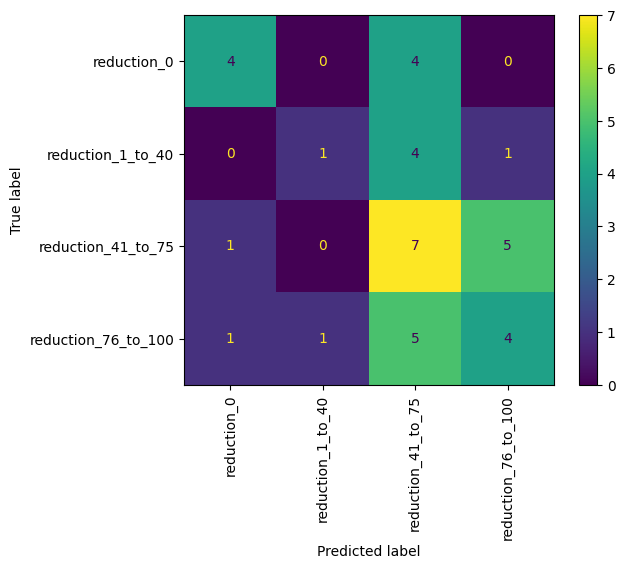

In [42]:
cm = confusion_matrix(y_test, pred, labels=dt_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=dt_clf.classes_)
disp.plot(xticks_rotation='vertical')

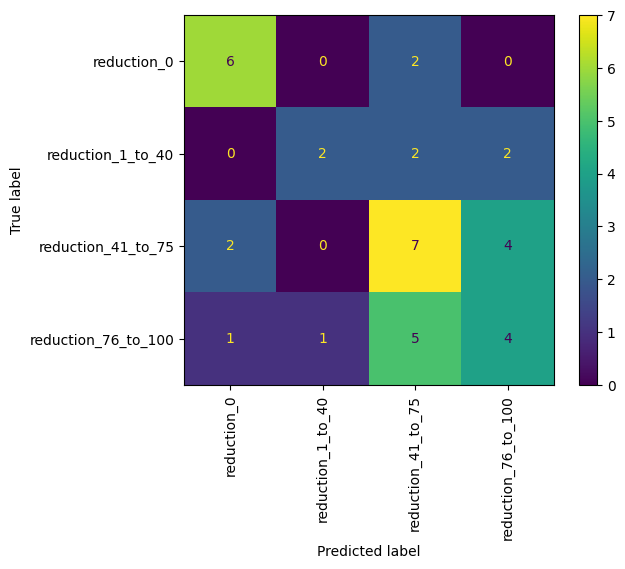

In [39]:
cm = confusion_matrix(y_test, pred, labels=dt_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=dt_clf.classes_)
disp.plot(xticks_rotation='vertical')

In [47]:
probas = dt_clf.predict_proba(X_test)

In [152]:
results_df = pd.DataFrame({
    'label': y_test,
    'model_predicted': pred,
    'probability_of_0_class': probas[:, 0],
    'reduction_1_to_40': probas[:, 1],
    'reduction_41_to_75': probas[:, 2],
    'reduction_76_to_100': probas[:, 3],
})

In [153]:
results_df[results_df.label == 'reduction_41_to_75']

,label,model_predicted,probability_of_0_class,reduction_1_to_40,reduction_41_to_75,reduction_76_to_100
77,reduction_41_to_75,reduction_41_to_75,0.10,0.05,0.68,0.17
16,reduction_41_to_75,reduction_76_to_100,0.01,0.02,0.41,0.56
97,reduction_41_to_75,reduction_41_to_75,0.10,0.09,0.75,0.06
113,reduction_41_to_75,reduction_41_to_75,0.13,0.11,0.55,0.21
83,reduction_41_to_75,reduction_41_to_75,0.06,0.06,0.67,0.21
35,reduction_41_to_75,reduction_0,0.39,0.13,0.28,0.20
65,reduction_41_to_75,reduction_41_to_75,0.15,0.03,0.62,0.20
15,reduction_41_to_75,reduction_76_to_100,0.10,0.05,0.33,0.52
86,reduction_41_to_75,reduction_41_to_75,0.02,0.04,0.68,0.26
28,reduction_41_to_75,reduction_0,0.47,0.04,0.40,0.09


In [68]:
from sklearn.linear_model import LogisticRegression

In [155]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

/Users/ktulhu/.pyenv/versions/3.9.15/envs/ve/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [156]:
pred = log_reg.predict(X_test)
print(classification_report(y_test, pred))

                     precision    recall  f1-score   support

        reduction_0       0.00      0.00      0.00         9
  reduction_1_to_40       0.09      0.20      0.13         5
 reduction_41_to_75       0.29      0.55      0.37        11
reduction_76_to_100       0.67      0.31      0.42        13

           accuracy                           0.29        38
          macro avg       0.26      0.26      0.23        38
       weighted avg       0.32      0.29      0.27        38



/Users/ktulhu/.pyenv/versions/3.9.15/envs/ve/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ktulhu/.pyenv/versions/3.9.15/envs/ve/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ktulhu/.pyenv/versions/3.9.15/envs/ve/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

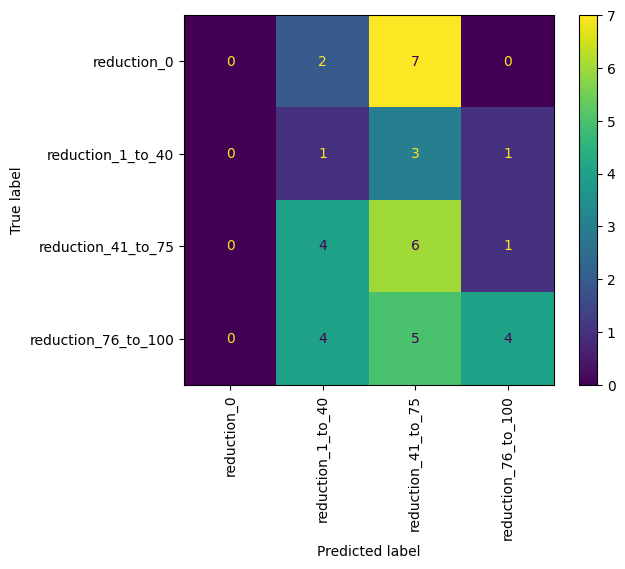

In [157]:
cm = confusion_matrix(y_test, pred, labels=log_reg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=log_reg.classes_)
disp.plot(xticks_rotation='vertical')

In [159]:
from sklearn.tree import DecisionTreeClassifier

In [160]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [161]:
pred = clf.predict(X_test)

In [162]:
print(classification_report(y_test, pred))

                     precision    recall  f1-score   support

        reduction_0       0.38      0.33      0.35         9
  reduction_1_to_40       0.00      0.00      0.00         5
 reduction_41_to_75       0.40      0.55      0.46        11
reduction_76_to_100       0.69      0.69      0.69        13

           accuracy                           0.47        38
          macro avg       0.37      0.39      0.38        38
       weighted avg       0.44      0.47      0.45        38



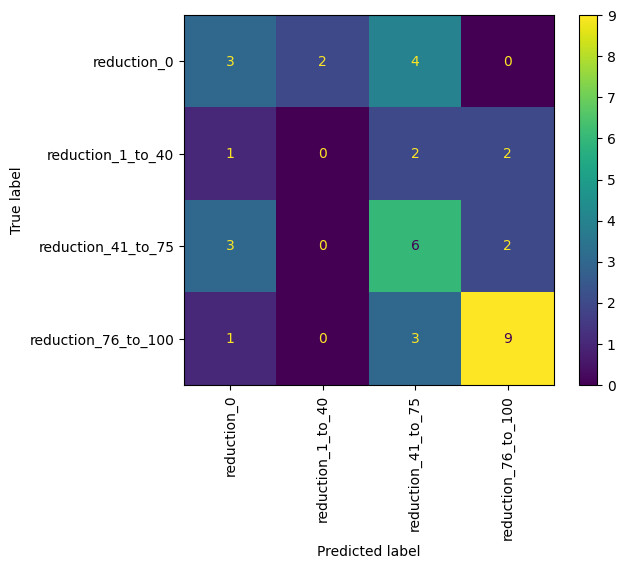

In [163]:
cm = confusion_matrix(y_test, pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot(xticks_rotation='vertical')